In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import datetime
import os
import time
import glob
import pandas as pd
import xarray as xr
from dateutil.relativedelta import relativedelta

import argparse

from model.utils import normalize, int_to_datetime

from model.mpnnlstm import NextFramePredictorS2S
from seq2seq import Seq2Seq

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

from ice_dataset import IceDataset

from model.graph_functions import create_static_heterogeneous_graph

In [11]:
device = torch.device('cpu')

# Defaults
convolution_type = 'TransformerConv'

training_years = range(2007, 2013)
x_vars = ['siconc', 't2m', 'v10', 'u10', 'sshf']
y_vars = ['siconc']  # ['siconc', 't2m']
input_features = len(x_vars)
input_timesteps = 10
output_timesteps= 90

binary=False

# Set threshold 
thresh = -np.inf
print(f'Threshold is {thresh}')

# Arguments passed to Seq2Seq constructor
model_kwargs = dict(
    hidden_size=32,
    dropout=0.1,
    n_layers=1,
    dummy=False,
    n_conv_layers=3,
    rnn_type='LSTM',
    convolution_type=convolution_type,
)

month = 4
ds = xr.open_mfdataset(glob.glob('data/hb_era5_glorys_nc/*.nc'))
mask = np.isnan(ds.siconc.isel(time=0)).values

graph_structure = create_static_heterogeneous_graph(mask.shape, 4, mask, use_edge_attrs=True, resolution=1/12, device=device)

data_val = IceDataset(ds, [2015], month, input_timesteps, output_timesteps, x_vars, y_vars)

experiment_name = f'M{str(month)}_Y{training_years[0]}_Y{training_years[-1]}_I{input_timesteps}O{output_timesteps}'

model = NextFramePredictorS2S(
    thresh=thresh,
    experiment_name=experiment_name,
    input_features=input_features,
    input_timesteps=input_timesteps,
    output_timesteps=output_timesteps,
    device=device,
    binary=binary,
    debug=False, 
    model_kwargs=model_kwargs)

results_dir = f'ice_results_may26_9_multires/'

model.load(results_dir)

Threshold is -inf


RuntimeError: Error(s) in loading state_dict for Seq2Seq:
	size mismatch for decoder.fc_out1.lin_key.weight: copying a param with shape torch.Size([32, 35]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for decoder.fc_out1.lin_query.weight: copying a param with shape torch.Size([32, 35]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for decoder.fc_out1.lin_value.weight: copying a param with shape torch.Size([32, 35]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for decoder.fc_out1.lin_skip.weight: copying a param with shape torch.Size([32, 35]) from checkpoint, the shape in current model is torch.Size([32, 32]).

In [ ]:
climatology = ds[y_vars].fillna(0).groupby('time.dayofyear').mean('time', skipna=True).to_array().values
climatology = torch.tensor(np.nan_to_num(climatology)).to(device)

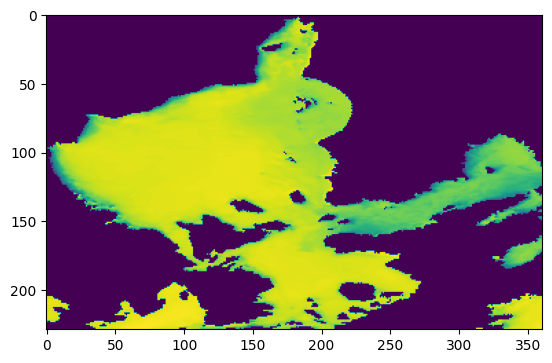

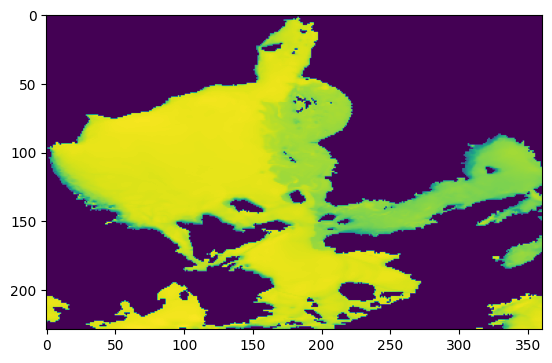

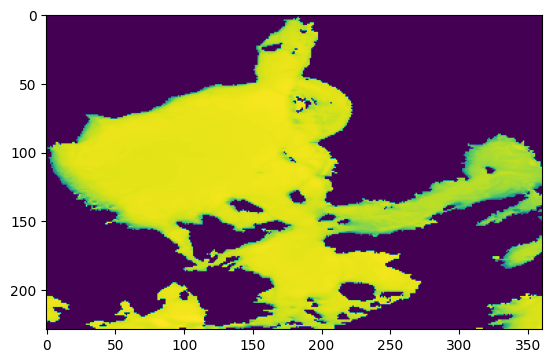

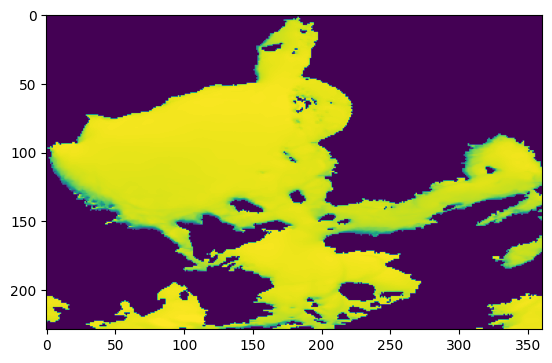

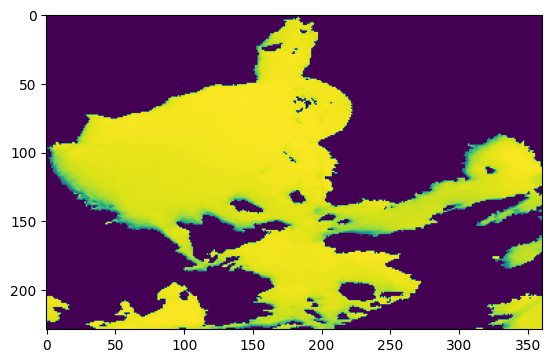

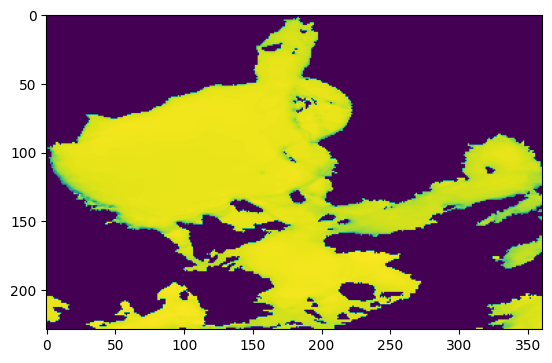

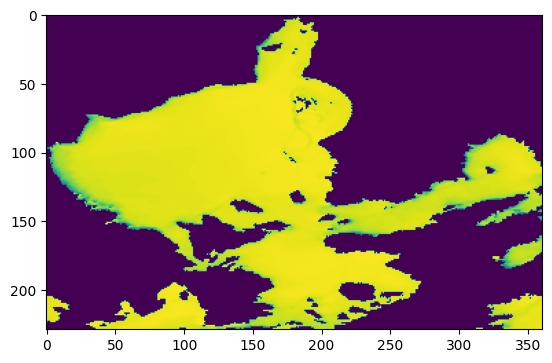

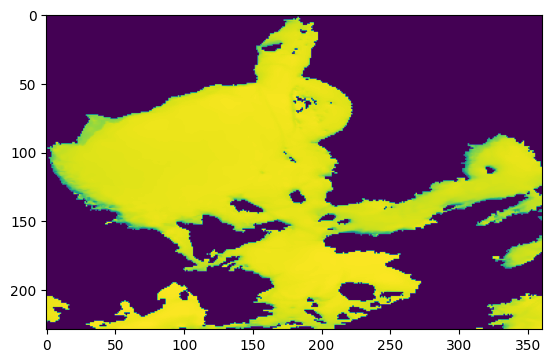

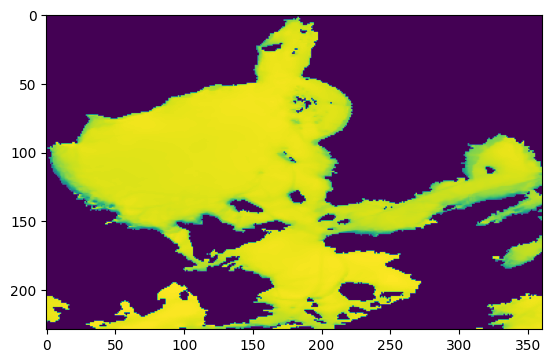

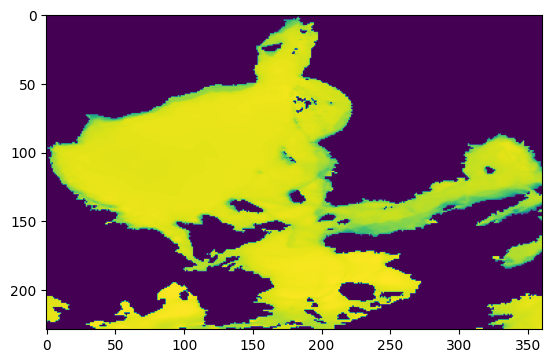

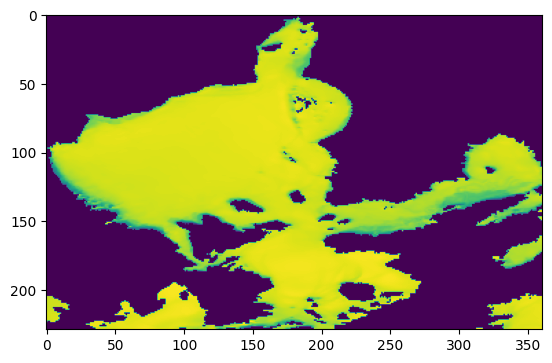

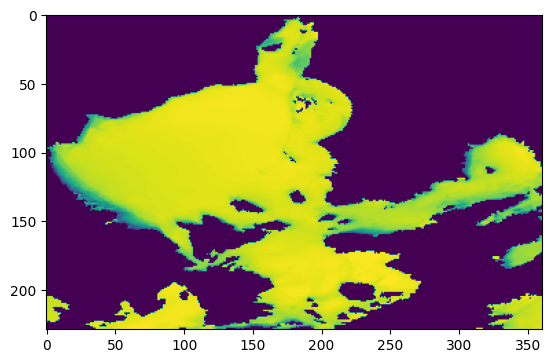

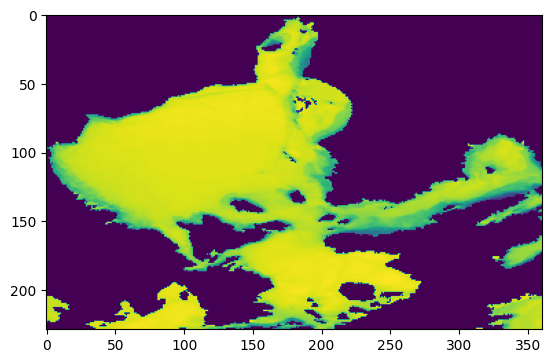

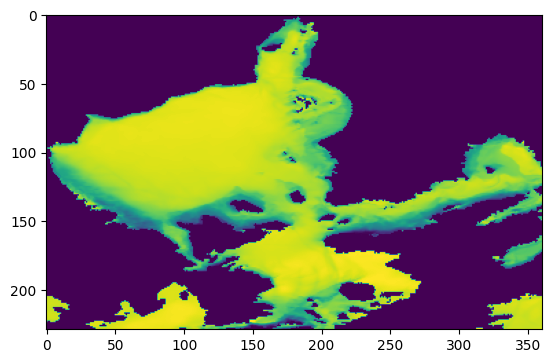

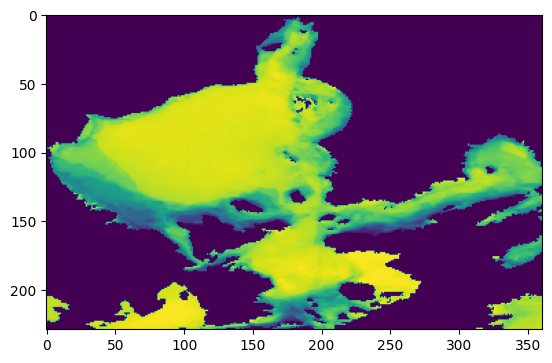

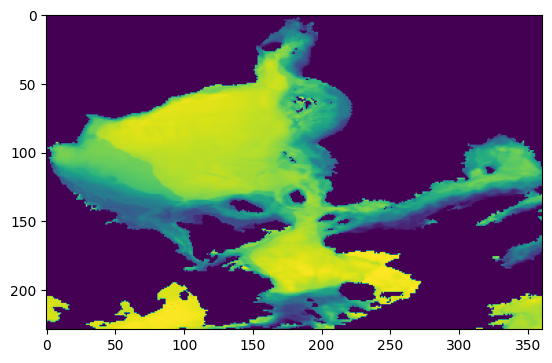

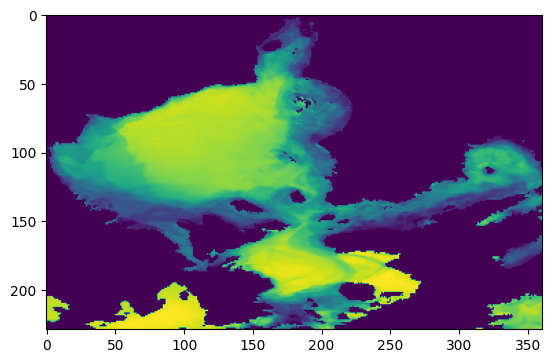

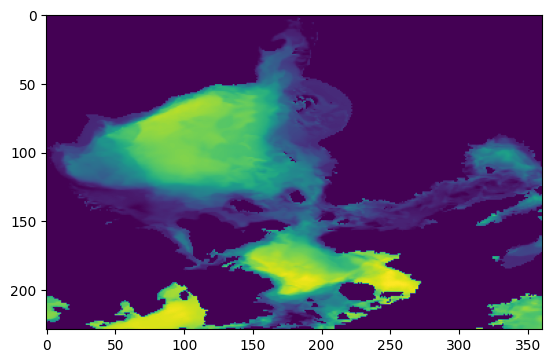

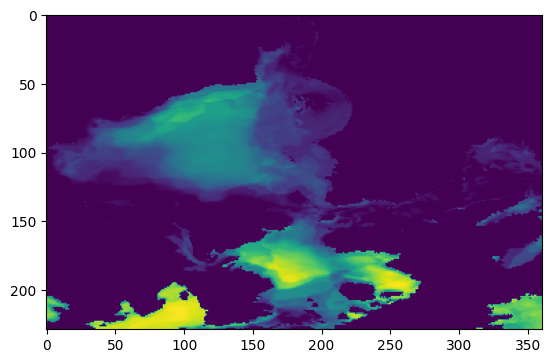

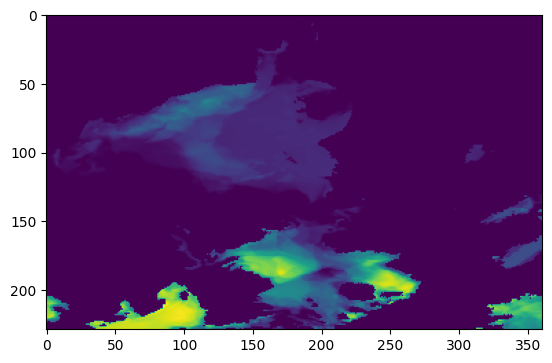

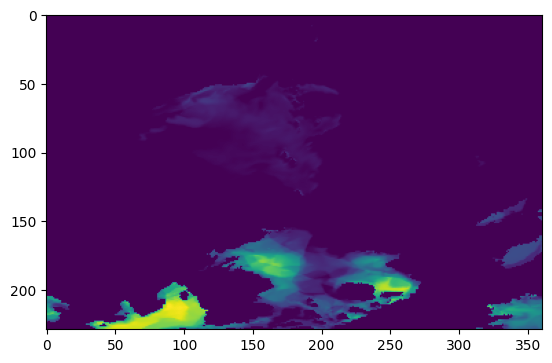

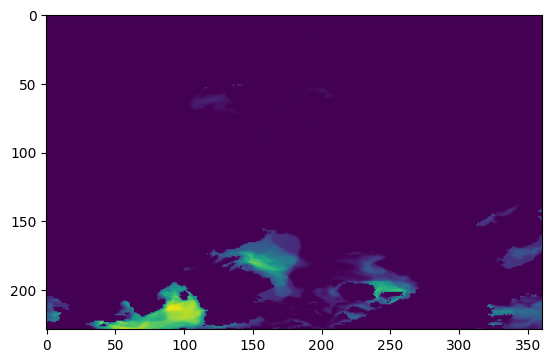

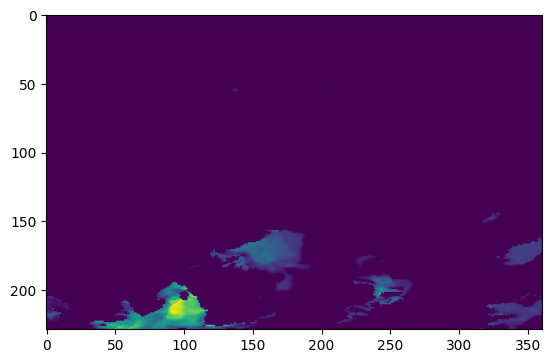

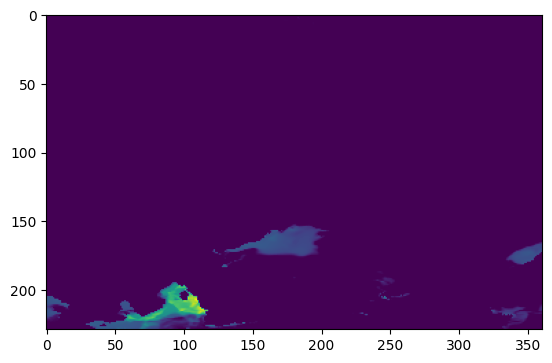

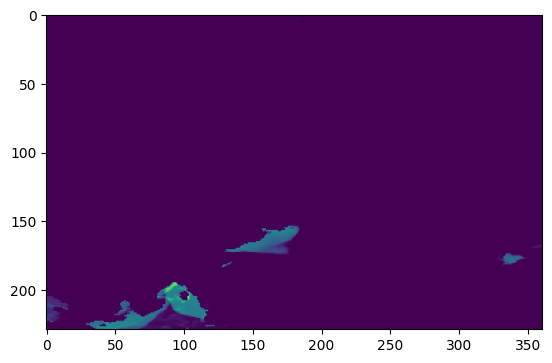

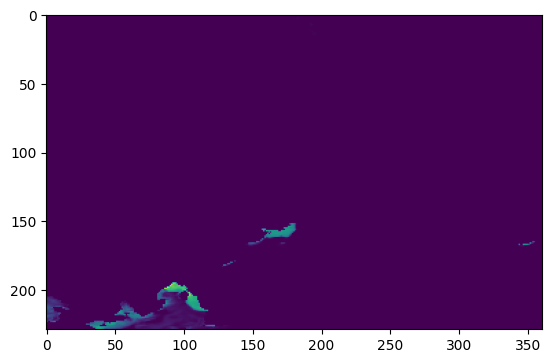

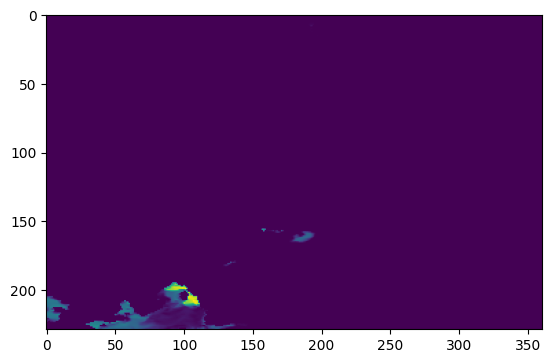

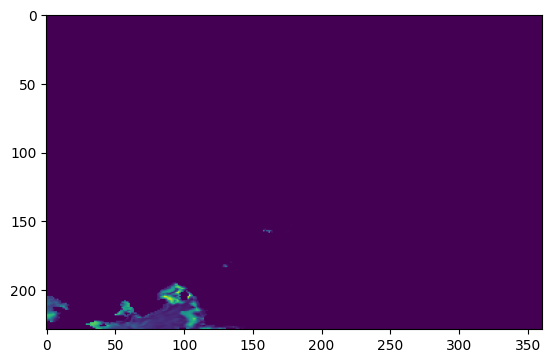

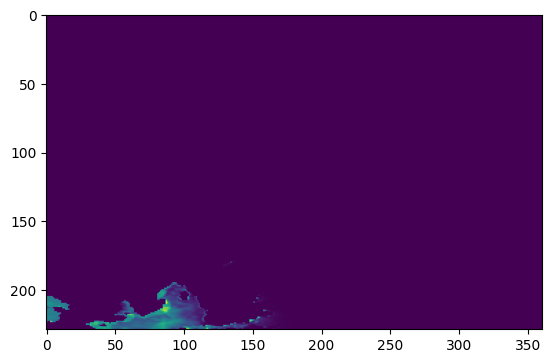

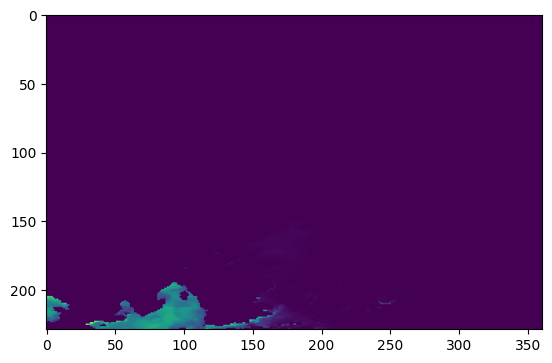

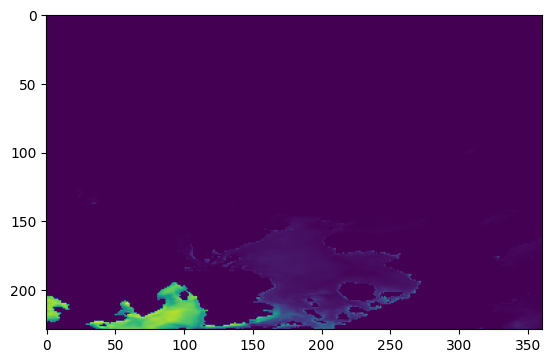

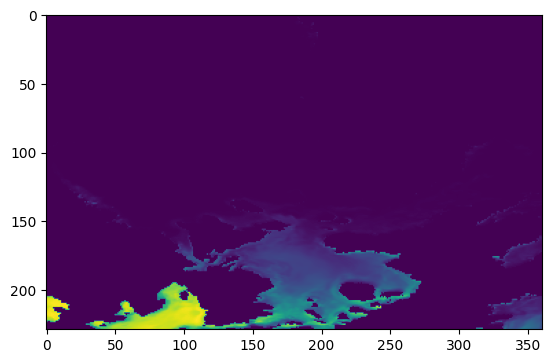

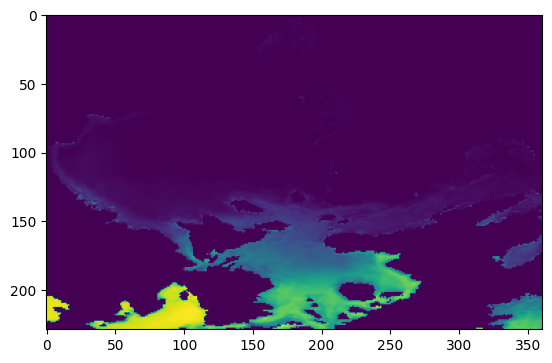

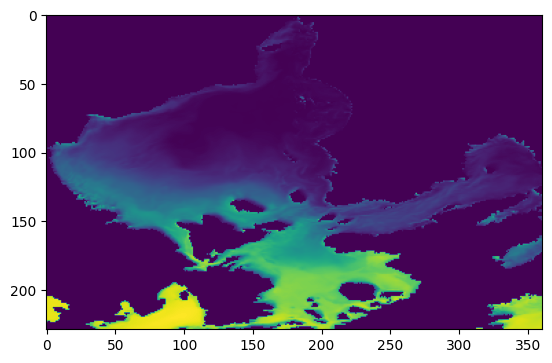

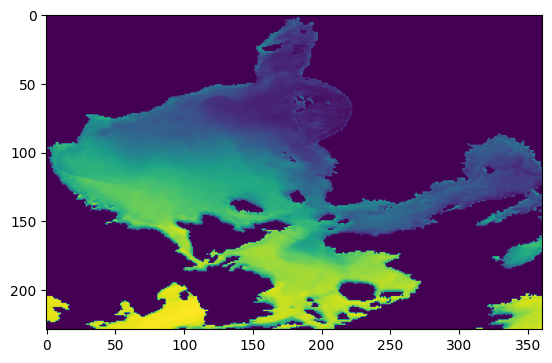

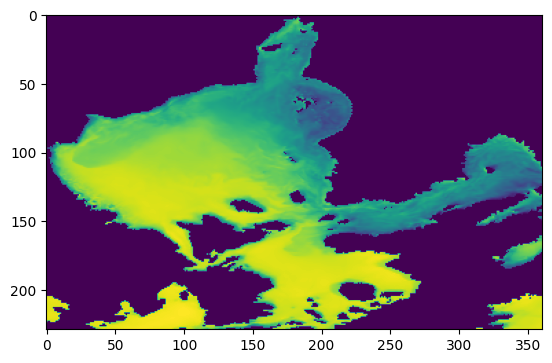

In [50]:
for i in np.arange(0, 360, 10):
    plt.imshow(climatology[0][i])
    plt.show()

In [ ]:
# Generate predictions
timestep = 15
loader_val = DataLoader(data_val, batch_size=1, shuffle=False, sampler=SubsetRandomSampler([timestep]))#, collate_fn=lambda x: x)
launch_date = int_to_datetime(int(next(loader_val.__iter__())[-1]))
launch_doy = launch_date.timetuple().tm_yday
model.model.eval()
val_preds = model.predict(
    loader_val,
    # climatology,
    mask=mask,
    graph_structure=graph_structure
)

# Save results
ds_pred = xr.Dataset(
    data_vars=dict(
        y_hat=(["timestep", "latitude", "longitude"], val_preds.squeeze(-1).squeeze(0)),
        y_true=(["timestep", "latitude", "longitude"], loader_val.dataset.y[[timestep]].squeeze(-1).squeeze(0)),
        # climatology=(["timestep", "latitude", "longitude"], climatology[0, launch_doy:launch_doy+90]),
    ),
    coords=dict(
        longitude=ds.longitude,
        latitude=ds.latitude,
        timestep=np.arange(1, output_timesteps+1),
    ),
)

print(str(launch_date)[:10])
for ts in ds_pred.timestep:
    fig, axs = plt.subplots(1, 3, figsize=(8, 2))
    ds_pred.sel(timestep=ts).y_true.where(~mask).plot(ax=axs[0], vmin=0, vmax=1, add_colorbar=False)
    ds_pred.sel(timestep=ts).y_hat.where(~mask).plot(ax=axs[1], vmin=0, vmax=1, add_colorbar=False)
    # ds_pred.sel(timestep=ts).climatology.where(~mask).plot(ax=axs[2], vmin=0, vmax=1, add_colorbar=False)
    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')
    plt.show()